# UCB W207 Final Project: Spotify Genre Classification
#### Section 2 - April 2024
Nicholas Lin, Yoni Nackash, Rex Gao

## Introduction & Context

For our final project, we were interested in the problem of classifying musical genres, something which would be useful in a variety of business applications, such as part of the algorithm making recommendations for listeners on a music app, or automating metadata tagging when adding tracks to music database. We can envision how a machine-learning based classifier for musical genres might improve scalability and consistency in genre labelling, as well time saved in manual tagging that could more efficiently be placed elsewhere.

We used a [dataset of Spotify tracks](<https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset>) collected through Spotify's web API and made available through a Open Data Commons Open Database License from Kaggle by Maharshi Pandya. The data includes 114 different genres, each with 1,000 tracks, for a raw total of 114,000 rows in the entire dataset. Each track row contains various information and metrics based on the characteristics of the audio, such as tempo, key, loudness, and danceability. We will employ a variety of data analysis and machine learning techniques in order to predict genres for tracks, strictly using these audio characteristics. Training was done on a local machine with 1 14-core CPU, 40 GiB RAM, and 1 Intel-based 20 GiB memory GPU.

## 1. Data Preprocessing

In [1]:
# Import the libraries
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

pd.set_option('display.max_columns', None)

2024-04-15 17:31:39.365315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#loading the data
raw_df = pd.read_csv('spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
df = raw_df.copy()
print('Shape of dataframe:', df.shape)

# Remove null row
print('Step 1: Removing rows with NA')
df.dropna(inplace=True)

# Map explicit field to binary
df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
print("Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks")
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
print('Step 3: Drop tracks with more than one assigned genre')
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)] 

#Extra drop duplicates based on artists & track_name instead of track_id
print('Step 4: Drop rows with duplicated artist + track_name')
df = df.drop_duplicates(subset = ['artists','track_name'], keep = 'last')

# With duplicate tracks and tracks with multiple genres removed, drop unnecessary columns for classification
print("Step 5: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'")
df = df.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

print('Shape of dataframe:', df.shape)
print('Number of unique genres:', len(df['track_genre'].unique()))

Shape of dataframe: (114000, 21)
Step 1: Removing rows with NA
Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks
Step 3: Drop tracks with more than one assigned genre
Step 4: Drop rows with duplicated artist + track_name
Step 5: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'
Shape of dataframe: (68682, 15)
Number of unique genres: 112


#### Reasons for Dropping Duplicates
To preprocess the data, there were several steps. First, rows with NA values were removed. Next, the Unnamed: 0 column was dropped to identify dupilcate tracks based on track_id. Then, although songs may be a part of multiple genres in reality, for the purpose of simplifying our model, the tracks with multiple genres were dropped. Songs that were listed more than once under a different track_id were also dropped. After performing these various preprocessing activites, our data contains 68,682 rows, across 112 unique genres. Finally, columns that were not included as features in the model, such as track_name, album_name, and artist were dropped.

## 2. EDA

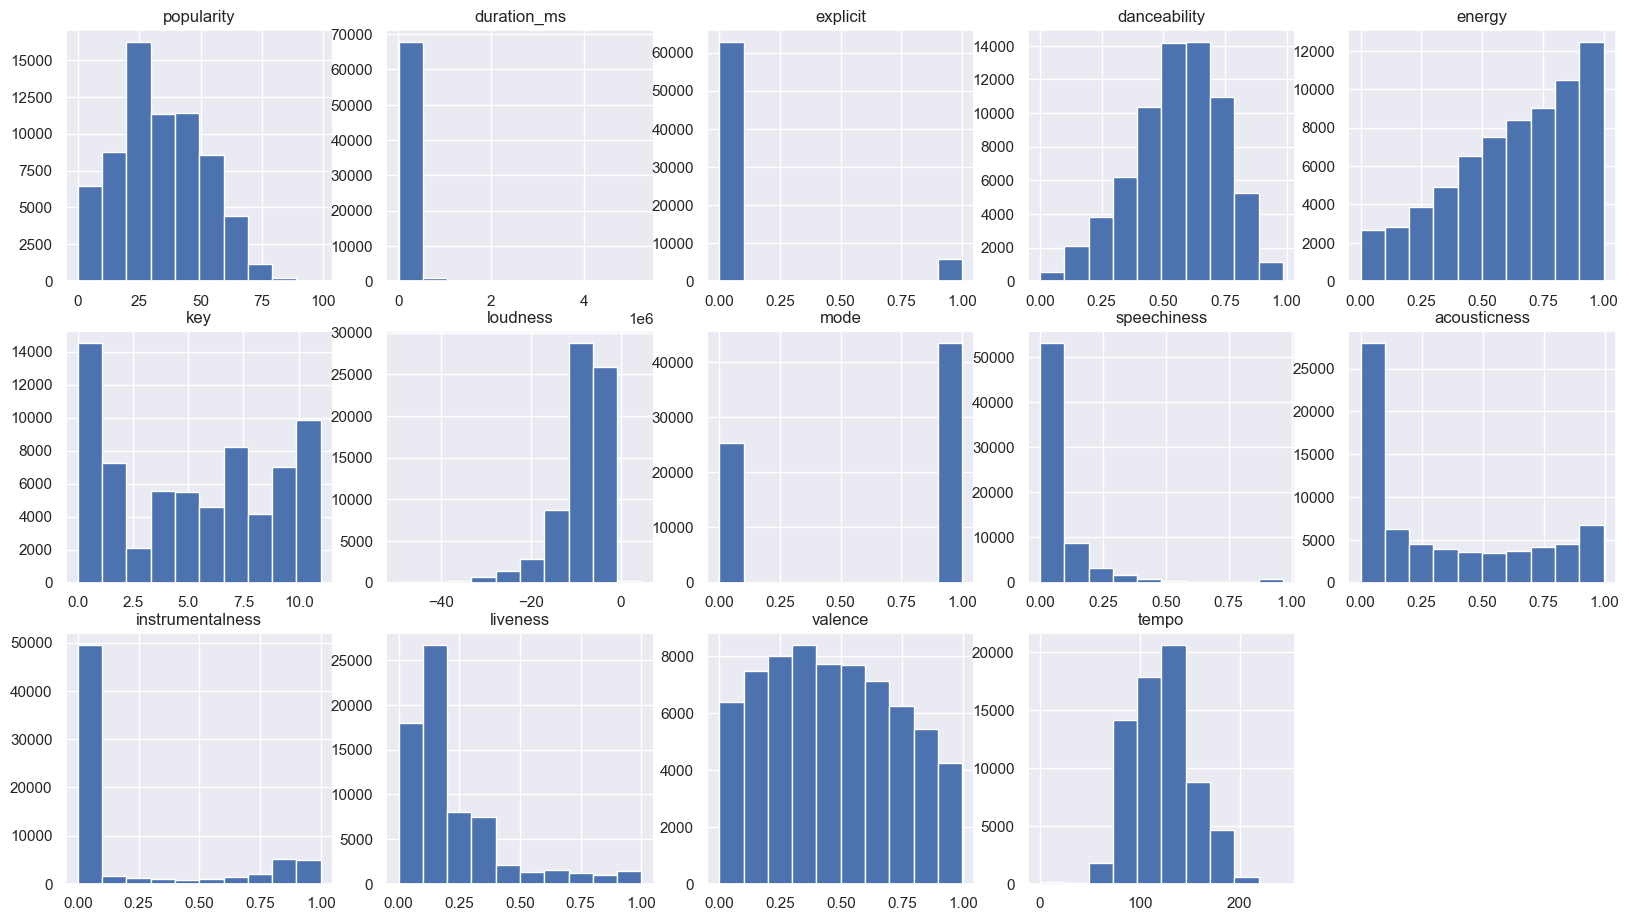

In [4]:
#Plotting feature histograms
features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(20, 15))
for i in range(len(features)):
  plt.subplot(4, 5, i+1)
  plt.hist(np.array(df[features[i]]))
  plt.title(features[i])
plt.show()

#### Analysis of Feature Histograms
Looking at the scales of each histogram, it is evident that most features are on different scales. Thus, some feature normalization would be beneficial to improve the performance of the model.

Taking a look at the duration_ms histogram, it is clear that are significant outliers. There seem to be a number of songs longer than the average song length. This is something we will keep an eye on, and may potentially remove.

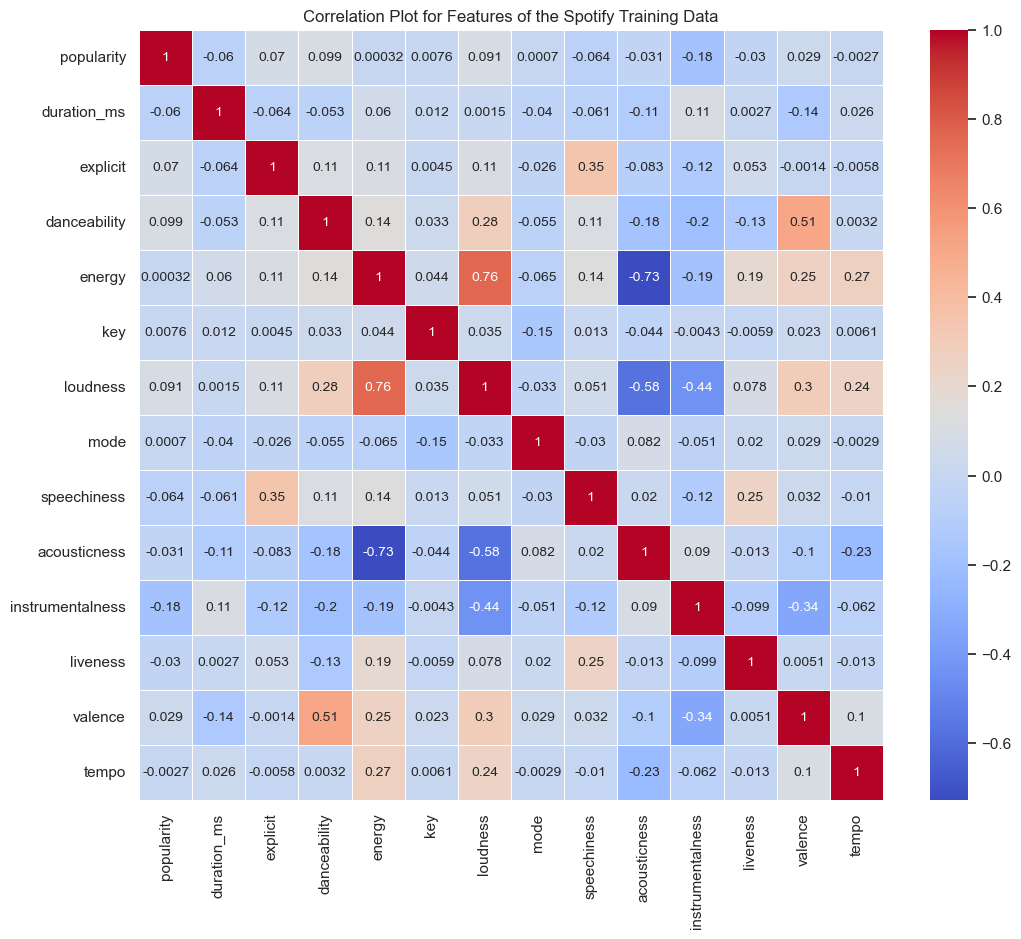

In [5]:
#Plotting correlation plot of the features
plt.figure(figsize=(12,10))
corr = df[features].corr()
sns.heatmap(corr, annot = True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Plot for Features of the Spotify Training Data')

plt.show()

#### Analysis of Correlation Plot
Based on the correlation plot, no two features seem extremely correlated with each other (~1.0). Thus, there are no redundant variables that may affect the model.

Speechiness and Explicit have a weak positive correlation, but could be a good indicator for songs in the genre of Rap.

Acousticness has a moderate to high negative correlation with energy (-0.73) and loudness (-0.58), showing that these features could be good indicators of different genres.

Loudness and energy have relatively high correlation with each other (0.76), along with valence and danceability (0.51), however it is important to note that they are still distinct as seen by correlation shared with other variables. Thus, they could also provide good insight as features.

## 3. Feature Engineering

In [6]:
# One hot encode key field
df = pd.get_dummies(df, columns=['key'], dtype=int)
df = df.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

df['popularity'] = df['popularity'].astype(int)
df['duration_ms'] = df['duration_ms'].astype(int)
df['mode'] = df['mode'].astype(int)

print(df.shape)
df.head()

(68682, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
2,57,210826,0,0.438,0.359,-9.734,1,0.0557,0.210,0.000000,0.117,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
14,56,188133,0,0.755,0.780,-6.084,1,0.0327,0.124,0.000028,0.121,0.387,120.004,acoustic,0,0,1,0,0,0,0,0,0,0,0,0
18,68,189613,0,0.625,0.414,-8.700,1,0.0369,0.294,0.000000,0.151,0.669,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
19,67,260186,0,0.717,0.320,-8.393,1,0.0283,0.830,0.000000,0.107,0.322,107.946,acoustic,0,0,0,1,0,0,0,0,0,0,0,0
21,63,174174,0,0.678,0.351,-8.654,1,0.0266,0.747,0.000000,0.355,0.569,90.032,acoustic,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Bin the popularity field
df['popularity_bin'] = pd.qcut(df.popularity,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['popularity_bin'], dtype=int)

# Remove tracks that are less than 60 seconds
df = df[df['duration_ms'] > 60000]

# Keep tracks with duration within 98th percentile
df = df[df['duration_ms'] < df['duration_ms'].quantile(.98)]

# Bin the duration_ms field
df['duration_bin'] = pd.qcut(df.duration_ms,q=4,labels=[1,2,3,4])
df = pd.get_dummies(df, columns=['duration_bin'], dtype=int)
df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,popularity_bin_1,popularity_bin_2,popularity_bin_3,popularity_bin_4,popularity_bin_5,duration_bin_1,duration_bin_2,duration_bin_3,duration_bin_4
2,57,210826,0,0.438,0.359,-9.734,1,0.0557,0.210,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
14,56,188133,0,0.755,0.780,-6.084,1,0.0327,0.124,0.000028,0.1210,0.3870,120.004,acoustic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
18,68,189613,0,0.625,0.414,-8.700,1,0.0369,0.294,0.000000,0.1510,0.6690,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
19,67,260186,0,0.717,0.320,-8.393,1,0.0283,0.830,0.000000,0.1070,0.3220,107.946,acoustic,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
21,63,174174,0,0.678,0.351,-8.654,1,0.0266,0.747,0.000000,0.3550,0.5690,90.032,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.235,-16.393,1,0.0422,0.640,0.928000,0.0863,0.0339,125.995,world-music,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0.117,-18.318,0,0.0401,0.994,0.976000,0.1050,0.0350,85.239,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0.329,-10.895,0,0.0420,0.867,0.000000,0.0839,0.7430,132.378,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113998,41,283893,0,0.587,0.506,-10.889,1,0.0297,0.381,0.000000,0.2700,0.4130,135.960,world-music,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


#### Explanation of Feature Engineering
Since popularity and duration_ms probably do not have a linear relationship with track genres, they were binned to reduce their noise and non-linearity. Furthermore, tracks less than 60 seconds long were removed, along with tracks that had too long of a length. This was done to help reduce tracks that may have been small sound bites that would not have had proper audio features to be part of a certain genre. Upon investigating tracks with extremely long lengths, it appeared that many of these were mixes or compilations, that may have included music across several genres.

#### Feature Selection

In [8]:
# Set features to use in model
features = [
    # 'popularity',
    # 'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'C',
    # 'C#',
    # 'D',
    # 'D#',
    # 'E',
    # 'F',
    # 'F#',
    # 'G',
    # 'G#',
    # 'A',
    # 'A#',
    # 'B',
    'popularity_bin_1',
    'popularity_bin_2',
    'popularity_bin_3',
    'popularity_bin_4',
    'popularity_bin_5',
    'duration_bin_1',
    'duration_bin_2',
    'duration_bin_3',
    'duration_bin_4'
]

# Load tracks and genre labels
tracks = df[features]
labels = df['track_genre']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of tracks  (66614, 19)
Shape of labels  (66614,)


#### Data Shuffling, Splitting, and Normalization

In [9]:
# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

In [10]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
genre_labels = df['track_genre'].unique()

In [11]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tracks, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

Shape of train images  (53291, 19)
Shape of train labels  (53291,)
Shape of test images  (13323, 19)
Shape of test labels  (13323,)


In [12]:
# Normalize the feature set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Baseline Model

Using a stratified dummy classifier as a baseline model, the classifier tries to retain the distribution of classes, while randomly assigning labels to each track. As shown below, the accuracy is extremely low, at around 0.01. Thus there is a lot of room for improvement regarding feature selection, engineering, and fixing class distributions.

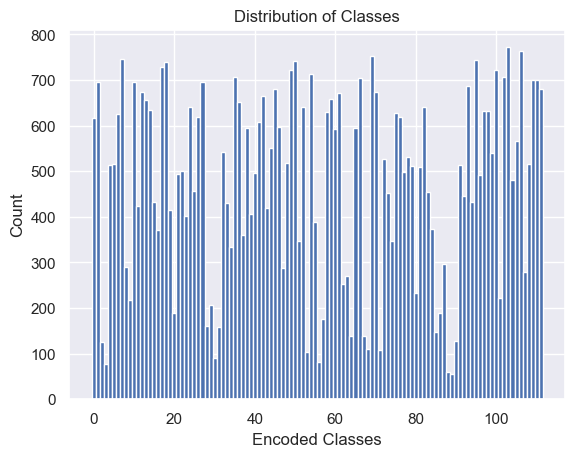

In [30]:
#show class distribution
unique, counts = np.unique(Y_train, return_counts = True)
class_counts = dict(zip(unique, counts))

plt.bar(class_counts.keys(), class_counts.values(), width=1)
plt.xlabel('Encoded Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes') 
plt.show()

In [31]:
#stratified baseline implementation
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train_scaled, Y_train)
Y_pred = dummy_clf.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=genre_labels)

print(f'Baseline Classifier Accuracy: {accuracy}')
print(f'Classification Report: {report}')

Baseline Classifier Accuracy: 0.011558958192599264
Classification Report:                    precision    recall  f1-score   support

         acoustic       0.01      0.01      0.01       179
         afrobeat       0.02      0.02      0.02       185
         alt-rock       0.00      0.00      0.00        28
      alternative       0.00      0.00      0.00        15
          ambient       0.01      0.01      0.01       147
            anime       0.03      0.03      0.03       120
      black-metal       0.00      0.00      0.00       161
        bluegrass       0.02      0.02      0.02       194
            blues       0.01      0.01      0.01        77
           brazil       0.00      0.00      0.00        50
        breakbeat       0.01      0.01      0.01       158
          british       0.02      0.02      0.02       105
         cantopop       0.02      0.02      0.02       164
    chicago-house       0.01      0.01      0.01       146
         children       0.01      0.01  

## 5. K-Nearest Neighbors

We decided to start our exploration with a k-nearest neighbors model, as it is one of the simplest multi-class classifiers, requiring no training step to make predictions, while still performing and generalizing quite well. To start with, we will use the default KNN classifier from sklearn without any hyperparameter tuning, and see what sort of results we get. As there is no training necessary, there is also no validation nor loss, so we will just look at the model accuracy and the classification report.

In [70]:
# k-nearest neighbors classifier with default hyperparameters
clf = KNeighborsClassifier()
clf.fit(X_train_scaled, Y_train)
Y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_pred)
# genre_labels to convert encoded labels to original strings, zero_division sets a default null value for divide-by-zero errors
report = classification_report(Y_test, Y_pred, target_names=genre_labels, zero_division=np.nan)

print(f"K-Nearest Neighbors Accuracy: {accuracy}")
print(f'Classification Report: {report}')

K-Nearest Neighbors Accuracy: 0.2683329580424829
Classification Report:                    precision    recall  f1-score   support

         acoustic       0.10      0.26      0.14       179
         afrobeat       0.13      0.26      0.18       185
         alt-rock       0.01      0.04      0.02        28
      alternative       0.04      0.13      0.06        15
          ambient       0.23      0.31      0.26       147
            anime       0.09      0.22      0.13       120
      black-metal       0.28      0.41      0.33       161
        bluegrass       0.20      0.40      0.27       194
            blues       0.04      0.08      0.05        77
           brazil       0.06      0.14      0.08        50
        breakbeat       0.18      0.27      0.22       158
          british       0.05      0.09      0.06       105
         cantopop       0.09      0.17      0.11       164
    chicago-house       0.29      0.44      0.35       146
         children       0.19      0.24    

After our initial KNN model training, we get an accuracy of around 0.27, which is a marked improvement from the 0.01 accuracy from our baseline dummy classifier, especially considering we are classifying between 112 different genres. We can further improve on this by tuning the hyperparameters, in particular the number of nearest neighbors (our k), the weight function used for predicting labels, and the distance metric, as these have the largest effects on the model. We can use an exhaustive grid search to help us with the fine tuning, which will run cross-validation through all combinations of parameters set in the parameter grid dictionary, and then return the set of parameters that produced the best overall score.

In [71]:
params = {'n_neighbors': [2, 4, 8, 16, 32, 64],
          'weights': ['uniform', 'distance'],
          'metric': ['cosine', 'euclidean', 'manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = params, verbose = 1, cv = 5, n_jobs = 1)
clf.fit(X_train_scaled, Y_train)
print(f'Best Parameters: {clf.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 32, 'weights': 'distance'}


Looking at the scores, we see that using distance as our weight function and Manhattan distance as our distance metric seems to work the best, and that our optimal number of nearest neighbors is close to 32. We will fine tune further on number of nearest neighbors, with less verbose output now that we know how the grid search works.

In [72]:
params = {'n_neighbors': range(24, 56, 4),
          'weights': ['distance'],
          'metric': ['manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = params, verbose = 1, cv = 5, n_jobs = 1)
clf.fit(X_train_scaled, Y_train)
print(f'Best Parameters: {clf.best_params_}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 32, 'weights': 'distance'}


In [73]:
params = {'n_neighbors': range(29, 35),
          'weights': ['distance'],
          'metric': ['manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = params, verbose = 1, cv = 5, n_jobs = 1)
clf.fit(X_train_scaled, Y_train)
print(f'Best Parameters: {clf.best_params_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 32, 'weights': 'distance'}


We find that using the 32 nearest neighbors with the inverse of Manhattan distance as weights produced the best accuracy:

In [74]:
clf = KNeighborsClassifier(n_neighbors = 32, weights = 'distance', metric = 'manhattan')
clf.fit(X_train_scaled, Y_train)
Y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=genre_labels, zero_division=np.nan)

print(f"K Nearest Neighbors Accuracy: {accuracy}")
print(f'Classification Report: {report}')

K Nearest Neighbors Accuracy: 0.3132177437514073
Classification Report:                    precision    recall  f1-score   support

         acoustic       0.17      0.23      0.20       179
         afrobeat       0.29      0.13      0.18       185
         alt-rock       0.00      0.00       nan        28
      alternative       0.00      0.00       nan        15
          ambient       0.39      0.28      0.32       147
            anime       0.25      0.16      0.19       120
      black-metal       0.47      0.38      0.42       161
        bluegrass       0.30      0.40      0.34       194
            blues       0.13      0.03      0.04        77
           brazil       0.15      0.06      0.09        50
        breakbeat       0.28      0.23      0.25       158
          british       0.05      0.01      0.02       105
         cantopop       0.13      0.20      0.16       164
    chicago-house       0.33      0.48      0.39       146
         children       0.29      0.24    

With an accuracy of around 0.31, we have some improvement compared to the default KNN classifier, however we begin to wonder why we're still mislabelling the majority of tracks. Looking further at the classification report, we noticed that we are getting very low precision or recall for some classes like punk or spanish, while others like grindcore and sleep are rather high. Some even have 0.00 precision and recall, but we noticed these tended to coincide with low support, with some genres like reggae and indie-pop only having around 5% of data compared to other genres.

## 6. K-Means Clustering

At this point, we begin to question how exactly the music labels were classified. In the real world, musical classification is often quite fluid. Individual songs can have a number of different influences and styles, which can make it difficult to classify a singular genre. As such, there could be a decent amount of subjectivity to the labels provided, and an argument could be made for certain genres to be condensed into higher-level categories.

In addition, it has become clear that there is significant overlap across genres that our models would not necessarily be able to recognize. For example, Pop, K-Pop, and Mandopop may all have relatively similar musical structure and features – however, without any explicit language tagged to the data, our model is likely confused, and therefore unable to successfully discern between these genres. There are also various genres, such as British or Brazil, that are most likely based on the artists' nationality, and may not refer to a speficic style of music. These genres may include music that span a variety of styles, which is further confusing the model.

To determine if our inability to produce accurate classifications is due to the large number of classes, overlapping features, and genre ambiguity, we turned our attention to creating a higher level of genre categorization. Our objective with genre categorization is to blend the different musical influences within a higher level music category. Through this, we hope to minimize the amount of information loss, while still being able to classify music into high level genres. Ideally, this will also help to avoid overfitting on the extremely detailed training data, and increase generalization.

For our first attempt at high level genre categorization, we performed a clustering activity. Our aim was to see if the clustering could take unlabeled data, and generate mutually exclusive clusters of similar genres.


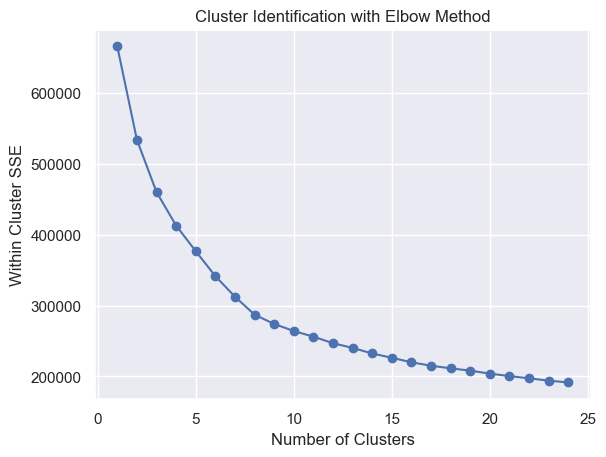

In [32]:
# Prepare data for clustering
cluster_data = tracks[['explicit', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']]
scaled_tracks = scaler.fit_transform(cluster_data)

cluster_list = []

# Build a range of KMeans models with different clusters
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i,           
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    kmeans.fit(scaled_tracks)
    cluster_list.append(kmeans.inertia_)
    
# Elbow plot to determine optimal cluster size
plt.plot(range(1,25), cluster_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster SSE')
plt.title('Cluster Identification with Elbow Method')
plt.show()

#### Elbow Method
We employed the Elbow Method to identify the ideal number of clusters. To do this, we built various KMeans cluster models with an increasing number of clusters, and plotted the within-cluster SSE for each model. We then identify the “elbow” of the plot - where the SSE begins to increase significantly. As we can see from the plot above, the optimal number of clusters in this case is 8.


In [33]:
# Define number of clusters 
number_of_clusters = 8
kmeans = KMeans(n_clusters = number_of_clusters, 
                n_init = 10,
                max_iter = 300,
                random_state = 0)

cluster_data['cluster'] = kmeans.fit_predict(scaled_tracks)

/var/folders/zb/c3btv_ts065cqcbw647frt2h0000gn/T/ipykernel_37910/476696804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['cluster'] = kmeans.fit_predict(scaled_tracks)


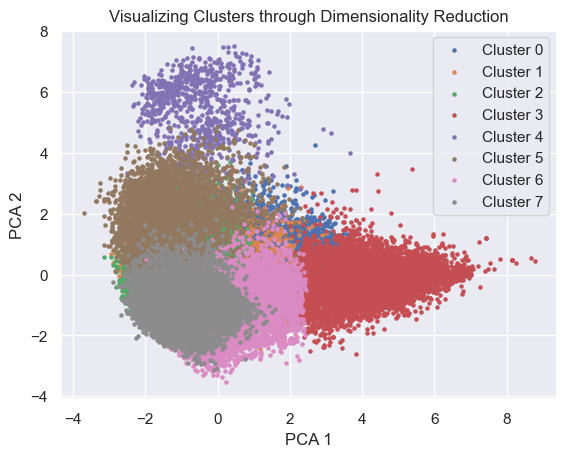

In [34]:
#Principal component analysis (dimensionality reduction) for visualisation
pca = PCA(n_components=2)
cluster_reduced = pca.fit_transform(scaled_tracks)

# Visualize the clusters through a scatter plot
for i in range(number_of_clusters):
    idx = cluster_data['cluster'] == i
    plt.scatter(cluster_reduced[idx, 0], cluster_reduced[idx, 1], label=f'Cluster {i}', alpha = 1, s=5)

plt.title('Visualizing Clusters through Dimensionality Reduction')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

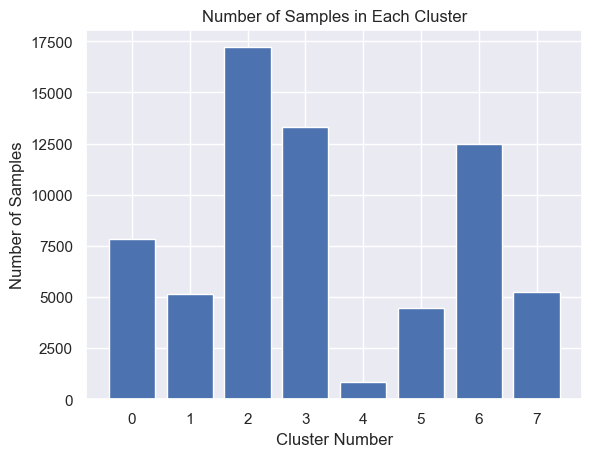

In [35]:
plt.bar(cluster_data['cluster'].unique(), cluster_data['cluster'].value_counts())
plt.title('Number of Samples in Each Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Samples')
plt.show()

In [36]:
warnings.simplefilter('ignore')
print('Number of unique genres in each cluster')
for i in range(number_of_clusters):
    print('Cluster',i,':',len(df[cluster_data['cluster']==i]['track_genre'].unique()))

Number of unique genres in each cluster
Cluster 0 : 110
Cluster 1 : 112
Cluster 2 : 111
Cluster 3 : 59
Cluster 4 : 41
Cluster 5 : 100
Cluster 6 : 96
Cluster 7 : 112


In [37]:
df[cluster_data['cluster']==4]['track_genre'].unique()

array(['afrobeat', 'ambient', 'brazil', 'children', 'chill', 'classical',
       'club', 'comedy', 'disney', 'drum-and-bass', 'dubstep', 'electro',
       'emo', 'folk', 'french', 'funk', 'garage', 'german', 'grindcore',
       'groove', 'hardcore', 'hip-hop', 'idm', 'iranian', 'j-dance',
       'jazz', 'k-pop', 'kids', 'latino', 'malay', 'metalcore', 'opera',
       'r-n-b', 'romance', 'sad', 'salsa', 'samba', 'show-tunes', 'study',
       'swedish', 'tango'], dtype=object)

#### Clustering Outcome
In order to better visualize our clusters, we performed principal component analysis - this is a dimensionality reduction activity that captures the largest variations in the data. While at first glance it appears we have generally distinct clusters, upon further investigation we found that the clustering activity did not create mutually exclusive clusters of similar genres - most genres are present across multiple clusters, with some clusters even containing all 112 unique genres. This in turn means that there are many varying styles of music present within each cluster, for example in cluster 4 we see Classical, Electronic, and Jazz.

While the clusters may contain tracks with similar characteristics, this does not necessarily seem to be helpful from a genre categorization perspective. We are interested in building a model that will learn the characteristics and relationships within specific genres, so it would not be helpful to separate tracks with the same genre into different clusters. Therefore, we have decided not to move forward with the genre categorization created through clustering. 

## 7. Research & Manual Genre Mapping

Given the unsuccessful clustering activity, we next experimented with a manual genre categorization. Considering the relative subjectivity of music label tagging, and how musical influence and style may bleed across several genres, it may be a bit more of an "art" than a "science" to successfully aggregating low-level genre classes into higher-level genre categories.

After a decent amount of research and investigation, it became clear that several prolific genres that appear most often in the real world, and that many sub-genres can be mapped under, are Rock, Pop, Electronic Dance Music, Hip-Hop/R&B, Country, Classical, and Latin & Reggaeton.

At this point, our team discussed the issue of potential cultural appropriation - we want to avoid accidentally grouping certain genres that we may not be fully familiar with into higher level categories that may not accurately represent the underlying music. For the purposes of this project, we chose to include a subset of the existing genres that we are knowledgeable on.

Sources: 
* https://rateyourmusic.com/genres/
* https://blog.novecore.com/top-10-most-popular-music-genres/
* https://www.statista.com/chart/30575/share-of-us-respondents-that-listens-to-different-music-genres/
* https://mastersofmedia.hum.uva.nl/blog/2011/04/26/visualising-music-the-problems-with-genre-classification/
* https://musicmachinery.com/2013/09/22/5025/

In [38]:
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    'punk': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'funk': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Country
    'country': 'Country',
    'bluegrass': 'Country',
    'honky-tonk': 'Country',

    # Classical
    'classical': 'Classical', 
    'opera': 'Classical', 
    
    # Pop
    'pop': 'Pop', 
    'k-pop': 'Pop', 
    'pop-film': 'Pop', 
    
    # Latin & Reggaeton
    'latin': 'Latin & Reggaeton', 
    'latino': 'Latin & Reggaeton', 
    'reggaeton': 'Latin & Reggaeton', 
    'salsa': 'Latin & Reggaeton',
    'samba': 'Latin & Reggaeton', 
}

# Map each track to a category
df['genre_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

slim_df = df[df['genre_category'] != 'Other']
slim_df.shape

(12282, 36)

#### Class Distribution Fixing

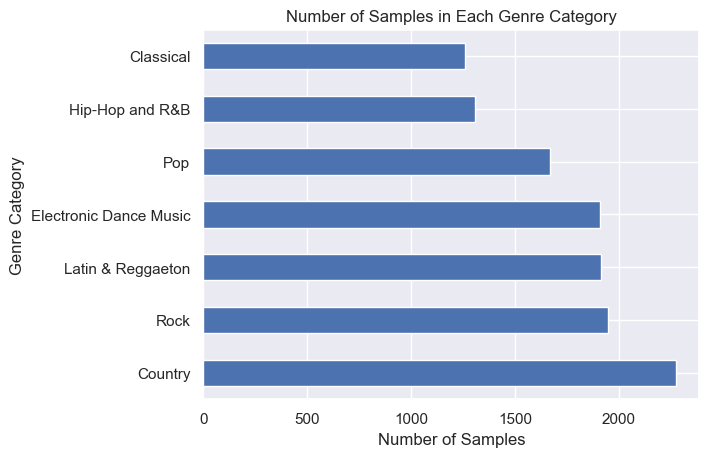

In [39]:
slim_df['genre_category'].value_counts().plot(kind='barh')
plt.title('Number of Samples in Each Genre Category')
plt.xlabel('Number of Samples')
plt.ylabel('Genre Category')
plt.show()

After our genre categorization, there is an uneven distribution of tracks. The class with the minimum number of tracks is Classical, with 1258 samples. To remedy this, we will rebalance the classes such that there are an equivalent number of examples in each class. We will shuffle the data prior to rebalancing. 

After rebalancing, we have around 8800 samples.

In [44]:
tracks = slim_df[features]
labels = slim_df['genre_category']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

Shape of tracks  (12282, 19)
Shape of labels  (12282,)


In [45]:
min_count = labels.value_counts().min()
result = {}
unique_classes = np.unique(labels)
for value in unique_classes:
    indices = np.where(labels==value)[0][:min_count]
    result[value] = indices.tolist()
index_values = list(result.values())
index_values = [element for nestedlist in index_values for element in nestedlist]
# tracks_scaled = tracks_scaled[index_values]
# labels_encoded = labels_encoded[index_values]
tracks = tracks.iloc[index_values]
labels = labels.iloc[index_values]

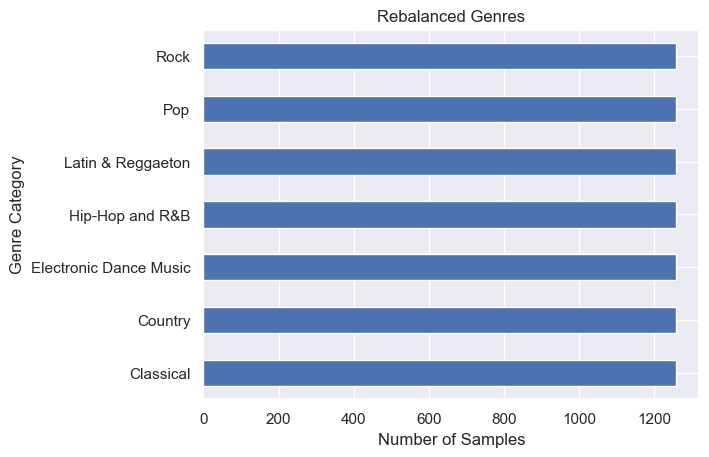

In [46]:
labels.value_counts().plot(kind='barh')
plt.title('Rebalanced Genres')
plt.xlabel('Number of Samples')
plt.ylabel('Genre Category')
plt.show()

In [47]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

In [48]:
#Resplit
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

Shape of train images  (7044, 19)
Shape of train labels  (7044,)
Shape of test images  (1762, 19)
Shape of test labels  (1762,)


## 8. K-Nearest Neighbors Revisted

Now that we have reduced and transformed our genres to more discrete, cohesive categories, we shall run a k-nearest neighbors classifier so that we can compare the improvement. We start once again with the default classifier.

In [88]:
clf = KNeighborsClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=labels.unique(), zero_division=np.nan)

print(f"K-Nearest Neighbors Accuracy: {accuracy}")
print(f'Classification Report: {report}')

K-Nearest Neighbors Accuracy: 0.6878547105561862
Classification Report:                         precision    recall  f1-score   support

             Classical       0.82      0.82      0.82       268
               Country       0.65      0.74      0.69       242
Electronic Dance Music       0.67      0.70      0.69       229
       Hip-Hop and R&B       0.67      0.70      0.68       264
     Latin & Reggaeton       0.70      0.73      0.71       238
                   Pop       0.58      0.59      0.59       258
                  Rock       0.73      0.55      0.63       263

              accuracy                           0.69      1762
             macro avg       0.69      0.69      0.69      1762
          weighted avg       0.69      0.69      0.69      1762



We get an accuracy of around 0.69, a massive improvement from even our fine-tuned model's accuracy of 0.31. We are able to capture a majority of correct genres for our balanced tracks. On top of the classification report, we can look at the confusion matrix now that we have a manageable number of classes.

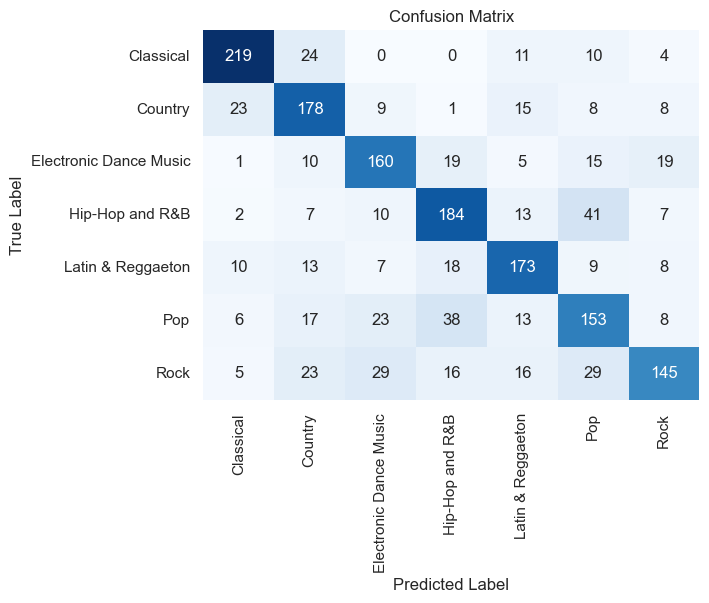

In [89]:
cm = confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues', xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

We see some confusion between pop and hip-hop/R&B, as well as some false negatives for rock, but otherwise, the results look quite good. Now let us fine tune the hyperparameters as we did before:

In [90]:
params = {'n_neighbors': [2, 4, 8, 16, 32, 64],
          'weights': ['uniform', 'distance'],
          'metric': ['cosine', 'euclidean', 'manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = params, verbose = 1, cv = 5, n_jobs = 1)
clf.fit(X_train, Y_train)
print(f'Best Parameters: {clf.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}


In [91]:
params = {'n_neighbors': range(9, 32),
          'weights': ['distance'],
          'metric': ['manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = params, verbose = 1, cv = 5, n_jobs = 1)
clf.fit(X_train, Y_train)
print(f'Best Parameters: {clf.best_params_}')

Fitting 5 folds for each of 23 candidates, totalling 115 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}


In [92]:
clf = KNeighborsClassifier(n_neighbors=12, weights='distance', metric='manhattan')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=labels.unique(), zero_division=np.nan)

print(f"K-Nearest Neighbors Accuracy: {accuracy}")
print(f'Classification Report: {report}')

K-Nearest Neighbors Accuracy: 0.7167990919409761
Classification Report:                         precision    recall  f1-score   support

             Classical       0.88      0.81      0.84       268
               Country       0.69      0.75      0.72       242
Electronic Dance Music       0.71      0.72      0.71       229
       Hip-Hop and R&B       0.73      0.69      0.71       264
     Latin & Reggaeton       0.75      0.76      0.75       238
                   Pop       0.58      0.72      0.65       258
                  Rock       0.71      0.57      0.63       263

              accuracy                           0.72      1762
             macro avg       0.72      0.72      0.72      1762
          weighted avg       0.72      0.72      0.72      1762



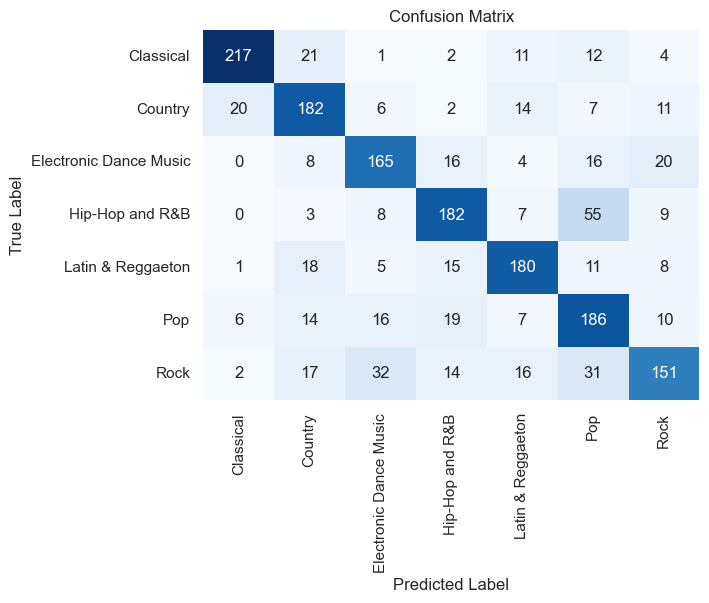

In [93]:
cm = confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues', xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

This time we have an optimal number of 12 nearest neighbors, and an accuracy of around 0.72. This is not a significant improvement over the 0.69 of our default KNN model, but it is still a good result. We can see an overall reduction in false negatives for pop, with 186 correctly identified tracks, compared to 153 with our default model, but there was not significant improvement in the other results to have a major impact on the accuracy. We decided to explore other models for multi-class classification to see if we can get better results.

## 9. Decision Trees

With some improvement seen in KNN after performing genre categorization, we next built a Decision Tree to try and classify the tracks. 

Model Accuracy on training set: 0.775
Model Accuracy on validation set: 0.701


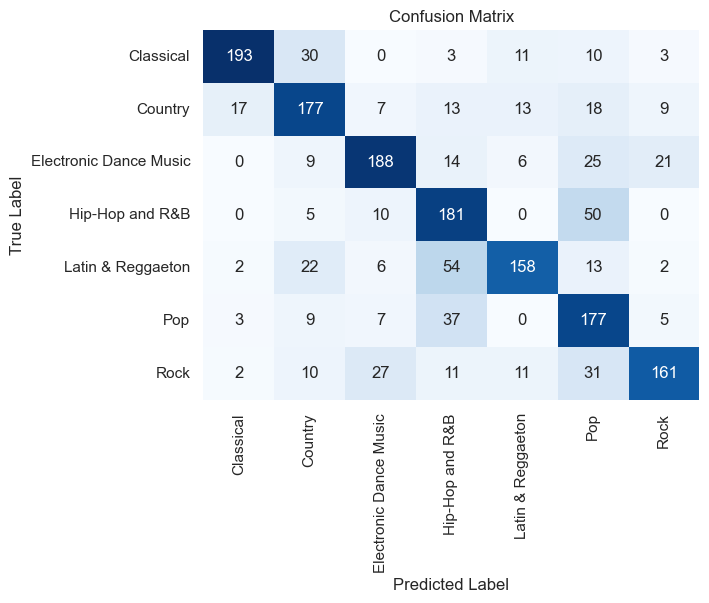

In [49]:
# Re-split the training set to get a validation set
X_train_dt, X_val_dt, Y_train_dt, Y_val_dt = train_test_split(X_train, Y_train, test_size = 0.25, random_state=42)

# Build RandomForestClassifier, and fit with X_Train_re, y_train
rf = RandomForestClassifier(
    n_estimators=17,
    n_jobs=1,
    random_state=7,
    max_depth=8,
    # max_features='log2'
)
rf.fit(X_train_dt, Y_train_dt)

# Evaluate model accuracy with X_train_re
print('Model Accuracy on training set:',round(rf.score(X_train_dt, Y_train_dt),3))  

# Evaluate model accuracy with X_val_re
print('Model Accuracy on validation set:',round(rf.score(X_val_dt, Y_val_dt),3))

# Plot Confusion Matrix using y_val, y_val_pred
Y_val_pred = rf.predict(X_val_dt)
cm = confusion_matrix(Y_val_dt, Y_val_pred)
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues', xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

After hyperarameter tuning, we found 17 estimators to be the ideal number of trees, with diminishing returns as we increased beyond that. Additionally, a max depth of 8 yielded the highest validation accuracy of 0.70, without overfitting on the training data and maintaining a train/validation accuracy differential within 10%.

Analyzing the confusion matrix above, it appears that Pop has the most false positives - the model is confusing a decent number of Hip-Hop/R&B tracks as Pop, with Pop having a precision of only 60% as seen in the chart below. The confusion matrix also reveals that Electronic Dance Music has a sizable amount of false negatives, with a recall of 65% - it seems there are a decent amount of Electronic Dance Music tracks that are being confused for Rock and Pop. 

In [51]:
metrics_df = pd.DataFrame(columns = ['Genre','Precision','Recall'])  
metrics_df['Genre'] = labels.unique()

for i in range(labels_count):
    precision = tf.keras.backend.get_value(cm[:,i][i]) / np.sum(tf.keras.backend.get_value(cm[:,i]))
    recall = tf.keras.backend.get_value(cm[:,i][i]) / np.sum(tf.keras.backend.get_value(cm[i,:]))
    metrics_df.loc[metrics_df['Genre'] == labels.unique()[i], 'Precision'] = precision
    metrics_df.loc[metrics_df['Genre'] == labels.unique()[i], 'Recall'] = recall

metrics_df

,Genre,Precision,Recall
0,Classical,0.889401,0.772
1,Country,0.675573,0.69685
2,Electronic Dance Music,0.767347,0.714829
3,Hip-Hop and R&B,0.578275,0.735772
4,Latin & Reggaeton,0.79397,0.614786
5,Pop,0.546296,0.743697
6,Rock,0.800995,0.636364


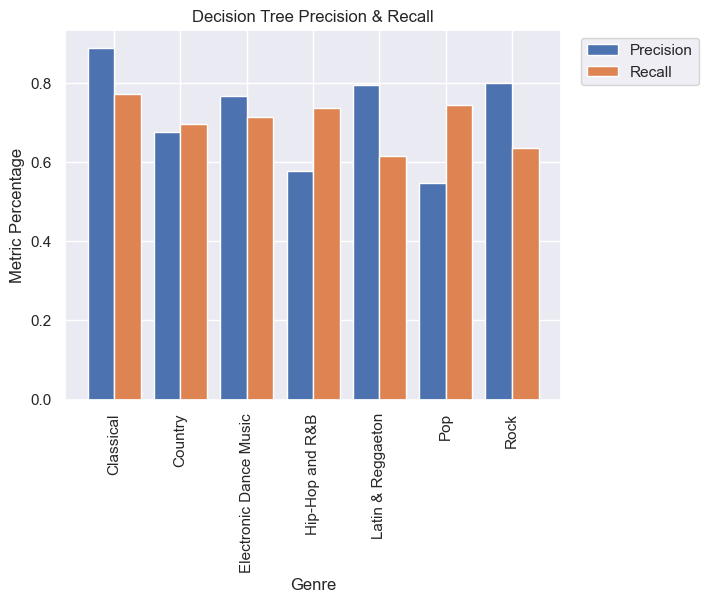

In [52]:
X_axis = np.arange(len(metrics_df['Genre'].unique()))

plt.bar(X_axis - 0.2, metrics_df['Precision'], 0.4, label = 'Precision')
plt.bar(X_axis + 0.2, metrics_df['Recall'],0.4, label = 'Recall')

plt.xticks(X_axis, metrics_df['Genre'].unique())
plt.xlabel("Genre") 
plt.ylabel("Metric Percentage") 
plt.title("Decision Tree Precision & Recall") 
plt.legend(loc=(1.04, .85))
plt.xticks(rotation = 90)
plt.show() 

## 10. Neural Networks

#### Model 1: Single Layer

Next, we turned our attention to Neural Networks to try and improve our classification accuracy. Ideally, neutral networks will be able to identify more nuance between the music characteristics, and yield better classification results. We started with a simple model with a single layer.

In [53]:
def build_model_single(num_features, n_classes,learning_rate=0.1):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

In [54]:
model = build_model_single(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()

Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 140       
                                                                 
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


2024-04-15 17:57:39.459277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=15,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=0             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.654302,0.385387,1.238911,0.585463
1,1.086974,0.639599,1.025255,0.655309
2,0.971090,0.669885,0.951097,0.677456
3,0.924785,0.681431,0.913361,0.686542
4,0.899683,0.688813,0.888951,0.704713
5,0.883463,0.691842,0.873696,0.713799
6,0.872318,0.695438,0.863359,0.710960
7,0.864252,0.697520,0.854307,0.714935
8,0.857878,0.697899,0.847308,0.714367
9,0.852840,0.701306,0.842445,0.713231


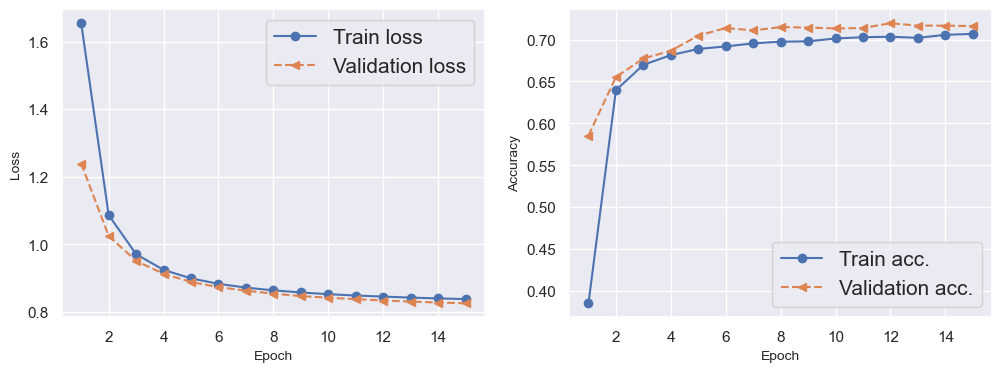

In [56]:
epoch_list = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epoch_list, history['loss'], '-o', label='Train loss')
ax.plot(epoch_list, history['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Loss', size=10)

ax = fig.add_subplot(1, 2, 2)
ax.plot(epoch_list, history['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(epoch_list, history['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Accuracy', size=10)
plt.show()

The single layer neural network yielded a validation accuracy of around 0.72, which is a slight improvement to the decision tree accuracy of 0.70, but no improvement as compared to the KNN accuracy which was also 0.72. 

#### Model 2: Multiple Layers
Next, we trained a model with multiple layers, and perform some hyperperameter tuning, adjusting the learning rate, optimization, number of epochs, and batch size. We found that a learning rate of 0.1, SGD optimization, 15 epochs, and batch size of 128 yielded minimal loss and the highest validation accuracy without overfitting on the training data. The differential between training and validation accuracy after 15 epochs is less than 1%. 

In [57]:
def build_model_multi(num_features, n_classes,learning_rate=.1):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=256,
            activation = 'relu'))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=128,
            activation = 'relu'))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

In [58]:
model = build_model_multi(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()

Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5120      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 38,919
Trainable params: 38,919
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=15,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=0             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.393324,0.547038,1.016059,0.675185
1,0.928582,0.687488,0.854316,0.704145
2,0.839508,0.703956,0.815784,0.721181
3,0.806432,0.714935,0.785600,0.729131
4,0.782251,0.722506,0.773374,0.733106
5,0.765026,0.725724,0.769031,0.728563
6,0.749616,0.734431,0.757526,0.734810
7,0.737357,0.738028,0.744223,0.737081
8,0.726569,0.735567,0.739088,0.740488
9,0.717277,0.739731,0.734128,0.737081


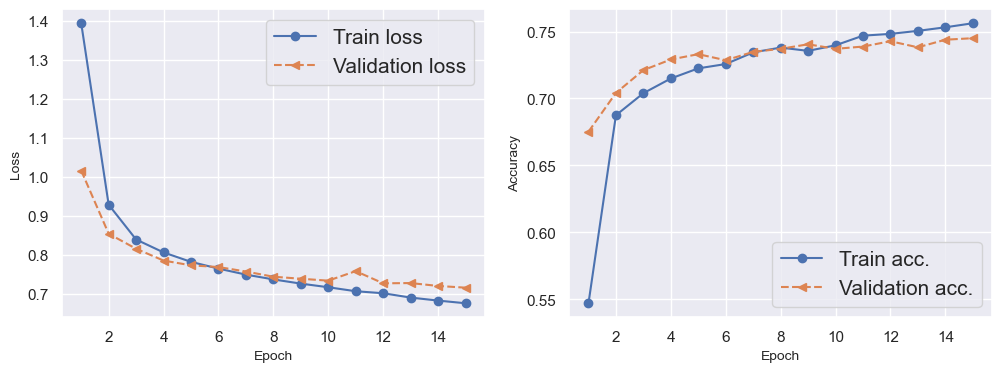

In [60]:
epoch_list = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
#plt.title('Loss and Accuracy Plots')
ax = fig.add_subplot(1, 2, 1)
ax.plot(epoch_list, history['loss'], '-o', label='Train loss')
ax.plot(epoch_list, history['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Loss', size=10)

ax = fig.add_subplot(1, 2, 2)
ax.plot(epoch_list, history['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(epoch_list, history['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Accuracy', size=10)
plt.show()

56/56 [==============================] - 0s 514us/step


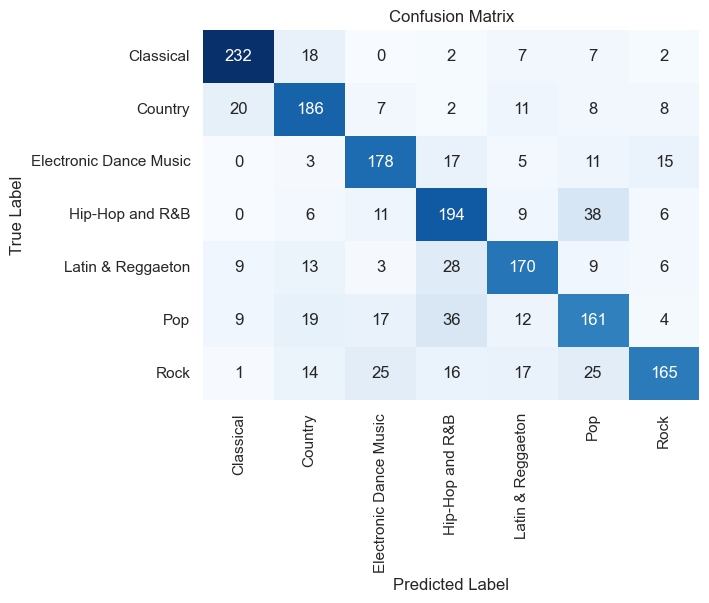

In [61]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [63]:
metrics_df = pd.DataFrame(columns = ['Genre','Precision','Recall'])  
metrics_df['Genre'] = labels.unique()

for i in range(labels_count):
    precision = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[:,i]))
    recall = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[i,:]))
    metrics_df.loc[metrics_df['Genre'] == labels.unique()[i], 'Precision'] = precision
    metrics_df.loc[metrics_df['Genre'] == labels.unique()[i], 'Recall'] = recall

metrics_df

,Genre,Precision,Recall
0,Classical,0.856089,0.865672
1,Country,0.718147,0.768595
2,Electronic Dance Music,0.738589,0.777293
3,Hip-Hop and R&B,0.657627,0.734848
4,Latin & Reggaeton,0.735931,0.714286
5,Pop,0.621622,0.624031
6,Rock,0.800971,0.627376


Our mutli-layer neural network yielded slightly higher validation accuracy results of around 0.75. It appears that the hidden layers of the neural network had success in understanding the relationships between the features, improving the validation accuracy without overfitting on the training data.

Next, we evaluated the model's performance on the test data to determine how well the model was able to gernalize to new data. We can see here that the testing accuracy is around 73%, and while this is slightly below our validation accuracy, it gives us confidence that our model is able to generalize well with new data.

In [65]:
test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,return_dict=True)['sparse_categorical_accuracy']
print('Test Accuracy for multi-layer model:', round(test_accuracy,3))

Test Accuracy for multi-layer model: 0.73


## Conclusion and Future Research

We were able to reach accuracies above 70% with all three of our models, each within 5% of one another, with the time and machine resources available to us. We saw the most succesful results with the multi-layer neural network, with a validation accuracy of 75%. Because of this relatively close grouping of results, we believe we may be approaching an upper limit on the amount of insight we are able to model, given the dataset and features. In the real world, musical genres are not fully discrete and often have influence across many styles of music. We also acknolwedge the potential limitation to aggregating genres into categories, such as involuntarily blending genres with very unique styles into a higher level category. For these reasons, we believe there is a reasonable possibility that there may be an upper limit to the accuracy attainable from our models.

In the event of continuing this experimentation in the future, we would be interested in investigating the possible benefits of language tagging, as suggested earlier. Capturing the language of tracks may allow us to categorize genres more cleanly, especially as many genres originate in different cultural regions. We would also be interested in performing further investigation and research into expanding our genre categorization. Future data scientists may be able to continue our categorization effort and map all of the 112 unique genres from this data set to higher-level categories. While we ultimately analyzed wider genre categories, our accuracy of 31% on just the unique genres through k-nearest neighbors is decent for 112 genres, and we believe there may be more potential.